In [0]:
# NOTES:
# 1. albumentations -> numpy
# 2. pil.open faster than cv2
# 3. 

# TODO
# 1. поддержка полутонового изображения
# 2. очень долго читаются картинки PIL + преобразования (мб их на GPU?)
# 3. 

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install colour-demosaicing

     |████████████████████████████████| 3.3MB 31.4MB/s 
     |████████████████████████████████| 1.6MB 48.2MB/s 


In [0]:
import numpy as np
import pandas as pd
import os

from pathlib import Path


import numpy as np
import torchvision
import matplotlib.pyplot as plt

import torch
from torchvision import transforms, models

from albumentations import Compose, ToGray, Normalize, RandomCrop, Resize
#from albumentations.pytorch import ToTensor
from torch.utils.data import Dataset, DataLoader

from PIL import Image
from colour_demosaicing import demosaicing_CFA_Bayer_Menon2007

print(os.listdir())

['.config', 'drive', 'sample_data']


In [0]:
def get_awgn_image(image, scale, loc=0.0):
    # scale = sigma
    noise3d = np.random.normal(loc=loc, scale=scale, size=image.shape)
    noisy_image = np.uint8(np.clip(image + noise3d, 0, 255))
    return noisy_image


def get_rgb_masks(shape):
    # GRBG
    g = np.zeros(shape)
    
    g[::2, ::2] = 1
    g[1::2, 1::2] = 1
    
    b = np.zeros(shape)
    b[1::2, ::2] = 1
    
    r = np.zeros(shape)
    r[::2, 1::2] = 1
    
    return r, g, b
    

def mosaic(image, rgb=True):
    h, w, _ = image.shape
    r_mask, g_mask, b_mask = get_rgb_masks((h,w))
    if rgb:
        blue, green, red = image[:, :, 2], image[:, :, 1], image[:, :, 0]
    else:
        blue, green, red = image[:, :, 0], image[:, :, 1], image[:, :, 2]
    return blue * b_mask + green * g_mask + red * r_mask


def mosaic_awgn_demosaic(image, sigma, rgb=True):
    mosaic_im = mosaic(image, rgb=rgb)
    noisy_mosaic_im = get_awgn_image(mosaic_im, sigma)
    demosaic_noisy_im = demosaicing_CFA_Bayer_Menon2007(noisy_mosaic_im, 'GRBG')
    if rgb:
        return demosaic_noisy_im
    # rgb to bgr
    return demosaic_noisy_im[:, :, [2, 1, 0]]


class ImageDataset(Dataset):

    def __init__(self, image_paths, augmentations=None, max_sigma=15):
        super().__init__()
        self.image_paths = image_paths
        self.size = len(image_paths)
        self.max_sigma = max_sigma
        self.augmentations = augmentations

    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        #image_idx = np.random.randint(0, self.size)
        image = self.load_image(self.image_paths[idx])
        #print(idx)
        
        mode = self.get_random_mode()
        sigma = self.get_random_sigma()
        
        if mode == 'awgn':
            noisy_im = get_awgn_image(image, sigma)
        else:
            noisy_im = mosaic_awgn_demosaic(image, sigma)
            
        noisy_im = np.array(noisy_im / 255., dtype='float32')
        
        label = 0 if mode == 'bayer' else 1
        
        return transform(self.augmentations(image=noisy_im)['image']), label, sigma

    def load_image(self, image_path):
        #print('Opening image... ', image_path )
        image = Image.open(image_path)
        image.load()
        # TODO дублирование по каналам, если изображение полутоновое
        return np.array(image)
    
    def get_random_mode(self):
        return np.random.choice(['awgn', 'bayer'])
    
    def get_random_sigma(self):
        return np.random.randint(0, self.max_sigma)

## Аугментация и деление на обучение и валидацию

In [0]:
class_names = ['bayer', 'awgn']

train_transforms = Compose([
    Resize(224,224),
    #RandomCrop(224,224),
    ToGray(p=1.0),
])

val_transforms = Compose([
    Resize(224,224),
    ToGray(p=1.0),
])

IMAGES_DIR = Path('drive/My Drive/dl_noise_classification/raw_images/')
im_paths = list(IMAGES_DIR.rglob('*.jpg'))
#print(im_paths[:10])
n_images = len(im_paths)
n_train = int(n_images * 0.8)

train_paths = im_paths[:20]
val_paths = im_paths[20:30]
print("Train size: {}\nValid size: {}".format(len(train_paths), len(val_paths)))

Train size: 20
Valid size: 10


In [0]:
train_dataset = ImageDataset(train_paths, train_transforms)
val_dataset = ImageDataset(val_paths, val_transforms)

batch_size = 10
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

## Пример одного батча из обучающих данных

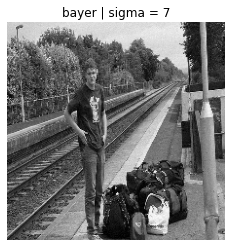

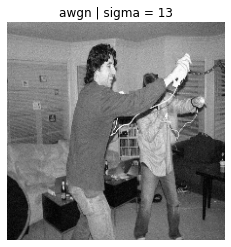

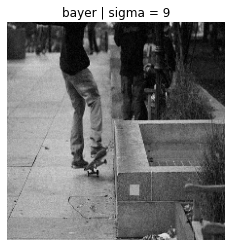

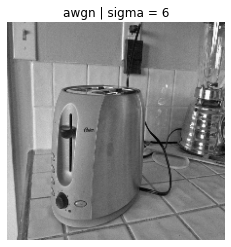

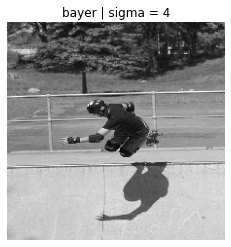

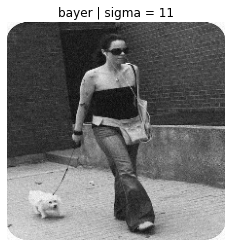

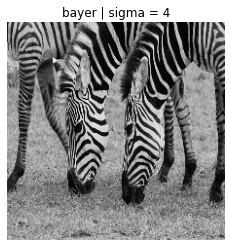

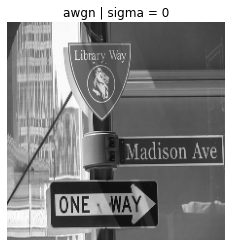

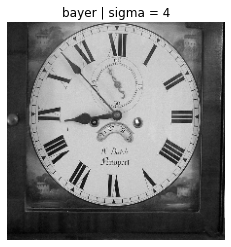

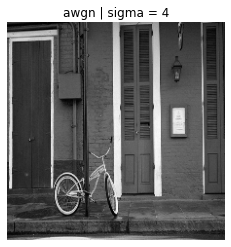

In [0]:
def show_input(input_tensor, title=''):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = input_tensor.numpy().transpose((1, 2, 0))
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.axis('off')
    plt.show()
    #plt.pause(0.001)

X_batch, y_batch, s_batch = next(iter(train_dataloader))

for x_item, y_item, sigma in zip(X_batch, y_batch, s_batch):
    show_input(x_item, title="{} | sigma = {}".format(class_names[y_item], sigma))

## 25 Случайных картинок из Train Dataset

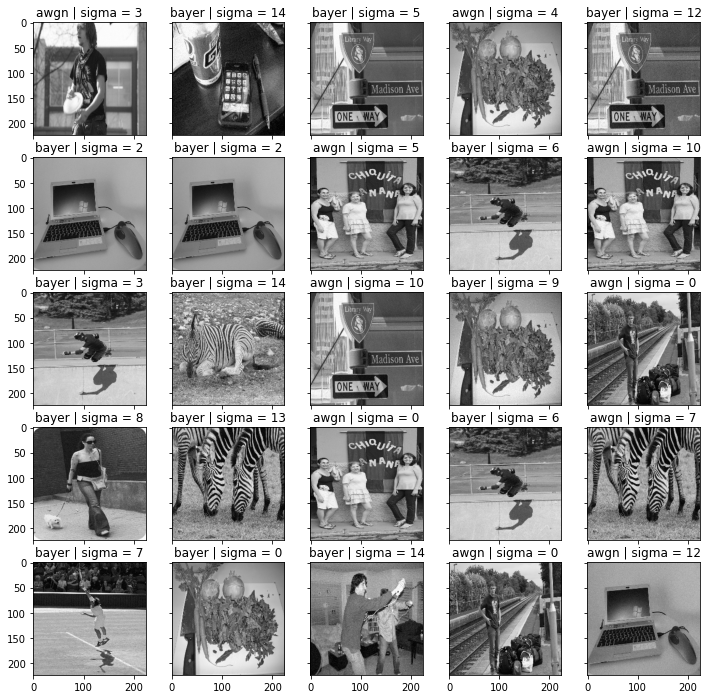

In [0]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

fig, ax = plt.subplots(nrows=5, ncols=5,figsize=(12, 12), sharey=True, sharex=True)

for fig_x in ax.flatten():
    random_plate = int(np.random.uniform(0, len(train_paths)))
    im_val, label, sigma = train_dataset[random_plate]
    imshow(im_val.data.cpu(), title="{} | sigma = {}".format(class_names[label], sigma), plt_ax=fig_x)

In [0]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    val_loss = []
    train_loss = []
    for epoch in range(num_epochs):

        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # training mode
            else:
                dataloader = val_dataloader
                model.eval()   # evaluate mode (dropout + bn)

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels, _ in dataloader:
                #print(inputs, labels)
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase=='train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.cpu().item()
                running_acc += (preds_class.cpu() == labels.cpu().data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            history = train_loss if phase == 'train' else val_loss
            history.append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return train_loss, val_loss

## Обучение сети ResNet152 с последним линейным слоем

In [0]:
#model = models.resnet152(pretrained=True)
model = models.resnet152(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

cuda:0


In [0]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)

# Decay LR by a factor of 0.5 every 20 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

In [0]:
loss_train_history, loss_val_history = train_model(model, loss, optimizer, scheduler, num_epochs=500)

Epoch 0/499:


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 39.0449 Acc: 0.5000
val Loss: nan Acc: 0.4000
Epoch 1/499:
train Loss: 2.3007 Acc: 0.5000
val Loss: nan Acc: 0.5000
Epoch 2/499:
train Loss: 7.5584 Acc: 0.6500
val Loss: nan Acc: 0.7000
Epoch 3/499:
train Loss: 19.2708 Acc: 0.4000
val Loss: nan Acc: 0.4000
Epoch 4/499:
train Loss: 2.8063 Acc: 0.5000
val Loss: 164124639697472179291116242206720.0000 Acc: 0.5000
Epoch 5/499:
train Loss: 17.6831 Acc: 0.4000
val Loss: 54363975184515724247826432.0000 Acc: 0.5000
Epoch 6/499:
train Loss: 4.1237 Acc: 0.6000
val Loss: 2088262570741380153344.0000 Acc: 0.6000
Epoch 7/499:
train Loss: 5.9029 Acc: 0.5000
val Loss: 75276800875298816.0000 Acc: 0.4000
Epoch 8/499:
train Loss: 2.5002 Acc: 0.3500
val Loss: 2206197729984512.0000 Acc: 0.5000
Epoch 9/499:
train Loss: 0.9979 Acc: 0.4500
val Loss: 11316367458304.0000 Acc: 0.5000
Epoch 10/499:
train Loss: 3.0828 Acc: 0.5500
val Loss: 19502669824.0000 Acc: 0.5000
Epoch 11/499:
train Loss: 1.7005 Acc: 0.5500
val Loss: 13547591680.0000 Acc: 0.5000
Ep

## PLOT Train and Val loss

In [0]:
torch.save(model.state_dict(), 'drive/My Drive/dl_noise_classification/20_train_epochs_500_pretrained.pth')

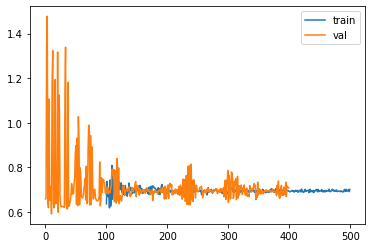

In [0]:
plt.plot(list(range(len(loss_train_history)))[100:], loss_train_history[100:], loss_val_history[100:])
plt.legend(["train", "val"])
plt.show()

In [0]:
plt.savefig('drive/My Drive/dl_noise_classification/train_val_loss_3.jpg')

<Figure size 432x288 with 0 Axes>

## Тестовая выборка и data loader

In [0]:
test_paths = im_paths[20:30]
test_dataset = ImageDataset(test_paths, val_transforms)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=10, shuffle=True, num_workers=0)

## Загрузка обученной модели

In [0]:
params_dict = torch.load('drive/My Drive/dl_noise_classification/20_train_epochs_500_pretrained.pth')
model = models.resnet152(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 2)
model.load_state_dict(params_dict)
model.eval()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = model.to(device)

cuda:0


In [0]:
from tqdm import tqdm

test_predictions = []
test_img_sigmas = []
test_true = []
for inputs, labels, sigmas in tqdm(test_dataloader):
    test_true.append(labels)
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_sigmas.extend(sigmas)
    
y_pred = np.concatenate(test_predictions)
y_true = np.concatenate(test_true)

100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


In [0]:
print(y_pred)

[ 0.5963852   0.49912643  0.49907893  0.49912548  0.49912336  0.49912614
  0.49912623  0.49912378  0.4991264   0.4991256 ]


In [0]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score


## ROC Curve

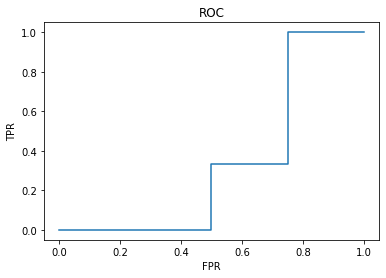

In [0]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(fpr, tpr)

In [0]:
thresholds

array([ 1.5963852 ,  0.5963852 ,  0.49912643,  0.49912623,  0.49912614,
        0.49912336,  0.49907893], dtype=float32)

In [0]:
y_true

array([0, 0, 0, 1, 1, 0, 1, 1, 1, 1])

In [0]:
print("AUC: {}".format(roc_auc_score(y_true, y_pred)))


AUC: 0.3333333333333333


## Точность в зависимости от порога

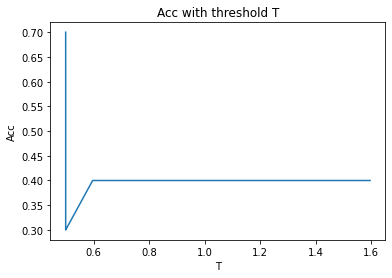

In [0]:
acc_history = []
t_history = []
for thresh in thresholds:
    y_hat = np.copy(y_pred)
    y_hat[y_hat > thresh] = 1
    y_hat[y_hat <= thresh] = 0
    accuracy = accuracy_score(y_true, y_hat)

    t_history.append(thresh)
    acc_history.append(accuracy)
    #print("Accuracy: {}, with threshold: {}".format(accuracy, thresh))

plt.title('Acc with threshold T')
plt.xlabel('T')
plt.ylabel('Acc')
plt.plot(t_history, acc_history)


array([ 0.47227594,  0.9996625 ,  0.5525067 ,  0.5744043 ,  0.5718775 ,
        0.60436624,  0.23836468,  0.659989  ,  0.5298564 ,  0.13553543,
        0.36954176,  0.5124735 ,  0.52312505,  0.52708185,  0.5880793 ,
        0.45013088,  0.56109136,  0.57235265,  0.5711936 ,  0.12979674,
        0.5353847 ,  0.6422717 ,  0.5695753 ,  0.59789217,  0.31670642,
        0.54615486,  0.47783807,  0.03903731,  0.5645977 ,  0.5616492 ], dtype=float32)